<a href="https://colab.research.google.com/github/MANOJHRMANOJHR/ai_assignments/blob/main/iris_logreg_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Logistic Regression 5-fold CV accuracy: 0.9533 ± 0.0452

Logistic Regression per-class metrics:
  class    prec     rec      f1  support
      0   1.000   1.000   1.000       50
      1   0.922   0.940   0.931       50
      2   0.939   0.920   0.929       50

Classification report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       0.92      0.94      0.93        50
   virginica       0.94      0.92      0.93        50

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150



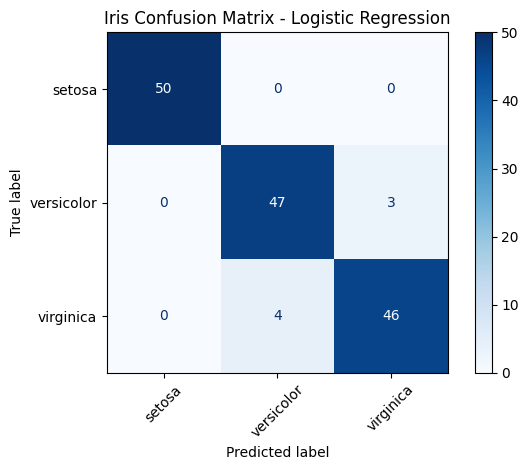

Saved: outputs/iris/cm_logistic_regression.png
Linear SVM 5-fold CV accuracy: 0.9267 ± 0.0533

Linear SVM per-class metrics:
  class    prec     rec      f1  support
      0   1.000   0.980   0.990       50
      1   0.898   0.880   0.889       50
      2   0.885   0.920   0.902       50

Classification report:
              precision    recall  f1-score   support

      setosa       1.00      0.98      0.99        50
  versicolor       0.90      0.88      0.89        50
   virginica       0.88      0.92      0.90        50

    accuracy                           0.93       150
   macro avg       0.93      0.93      0.93       150
weighted avg       0.93      0.93      0.93       150



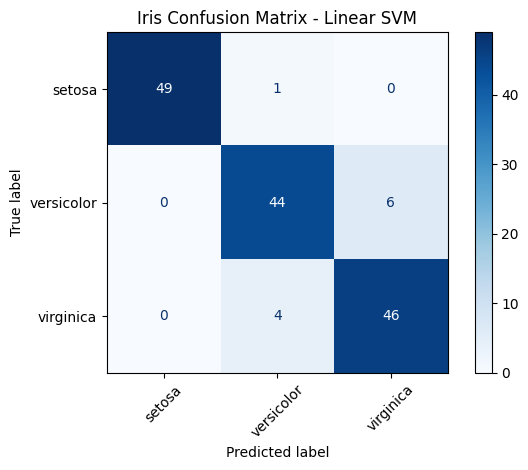

Saved: outputs/iris/cm_linear_svm.png


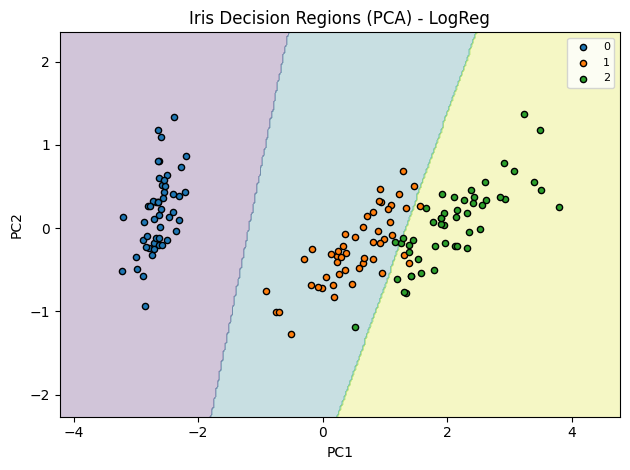

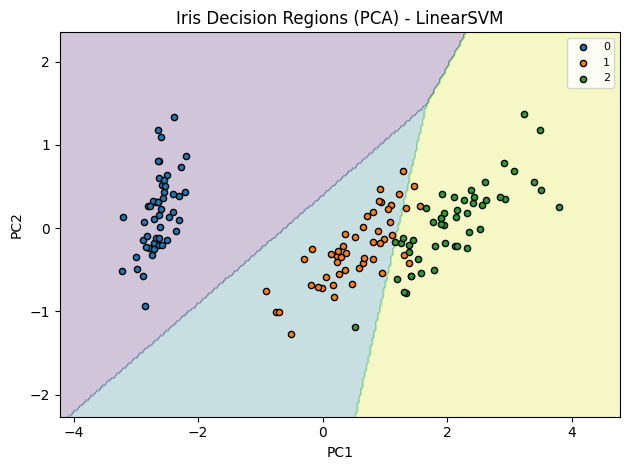

In [1]:
# iris_logreg_svm.py
# Logistic Regression & Linear SVM on Iris with standardization,
# 5-fold CV, confusion matrices, per-class precision/recall,
# and PCA(2D) decision plots.

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA


def ensure_out():
    os.makedirs("outputs/iris", exist_ok=True)


def pr_table(y_true, y_pred, labels):
    p, r, f1, sup = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, zero_division=0
    )
    header = f"{'class':>7} {'prec':>7} {'rec':>7} {'f1':>7} {'support':>8}"
    print(header)
    for c, pp, rr, ff, ss in zip(labels, p, r, f1, sup):
        print(f"{c:>7} {pp:7.3f} {rr:7.3f} {ff:7.3f} {ss:8d}")


def decision_plot_2d(model, X2d, y, title, fname, h=0.03):
    x_min, x_max = X2d[:, 0].min() - 1, X2d[:, 0].max() + 1
    y_min, y_max = X2d[:, 1].min() - 1, X2d[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.25)
    for c in np.unique(y):
        idx = (y == c)
        plt.scatter(X2d[idx, 0], X2d[idx, 1], s=20, edgecolors='k', label=str(c))
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()


def main():
    ensure_out()
    data = load_iris()
    X, y, names = data.data, data.target, data.target_names

    pipe_lr = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
          solver="lbfgs",
            max_iter=1000, n_jobs=-1))
    ])
    pipe_lsvm = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LinearSVC(C=1.0))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for label, model in [
        ("Logistic Regression", pipe_lr),
        ("Linear SVM", pipe_lsvm)
    ]:
        scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
        print(f"{label} 5-fold CV accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

        y_pred = cross_val_predict(model, X, y, cv=cv)
        cm = confusion_matrix(y, y_pred)

        print(f"\n{label} per-class metrics:")
        pr_table(y, y_pred, labels=[0, 1, 2])

        print("\nClassification report:")
        print(classification_report(y, y_pred, target_names=names, zero_division=0))

        disp = ConfusionMatrixDisplay(cm, display_labels=names)
        disp.plot(cmap="Blues", xticks_rotation=45)
        plt.title(f"Iris Confusion Matrix - {label}")
        out = f"outputs/iris/cm_{label.replace(' ', '_').lower()}.png"
        plt.tight_layout()
        plt.savefig(out, dpi=200)
        plt.show()
        print(f"Saved: {out}")

    # PCA(2D) visualization models (trained on 2D only for plotting)
    X2d = PCA(n_components=2, random_state=42).fit_transform(X)

    lr2d = LogisticRegression(
        solver="lbfgs", max_iter=1000
    ).fit(X2d, y)
    decision_plot_2d(lr2d, X2d, y, "Iris Decision Regions (PCA) - LogReg",
                     "outputs/iris/decision_lr.png")

    lsvm2d = LinearSVC(C=1.0).fit(X2d, y)
    decision_plot_2d(lsvm2d, X2d, y, "Iris Decision Regions (PCA) - LinearSVM",
                     "outputs/iris/decision_lsvm.png")


if __name__ == "__main__":
    main()
